# Query Language Model Evaluation

In [2]:
%load_ext autoreload
%autoreload 2
import json
import sys
import os
import pickle
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


from tqdm.notebook import tqdm
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from evaluation import *
from preprocessing import Corpus, BasicPreprocessing, BigramPreprocessor, SpacyPreprocessor, StopWordPreprocessor
from retrieval_algorithms import QueryLMRetrievalAlgorithm

In [3]:
def create_grid(scales):
    return [round(j*10**i,5) for i in scales for j in range(1,10)]

## Load corpus using different preprocessing pipelines

In [4]:
base_file =  "../../data/kit_expert_2019_all_papers.csv"

p = [BasicPreprocessing(), StopWordPreprocessor()]
papers_basic = Corpus(base_file, p)

p = [BasicPreprocessing(), StopWordPreprocessor(), SpacyPreprocessor(lemmatization="all")]
papers_basic_lemmatization_all = Corpus(base_file, p, load_from_cache=True, n_jobs=16)

p = [BasicPreprocessing(), StopWordPreprocessor(), SpacyPreprocessor(lemmatization="nouns")]
papers_basic_lemmatization_nouns = Corpus(base_file, p, load_from_cache=True, n_jobs=16)

INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_NoStopWords" for file ../../data/kit_expert_2019_all_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../../data/kit_expert_2019_all_papers_basic_NoStopWords
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_NoStopWords_spacy_lemmatization_all" for file ../../data/kit_expert_2019_all_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../../data/kit_expert_2019_all_papers_basic_NoStopWords_spacy_lemmatization_all
INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_NoStopWords_spacy_lemmatization_nouns" for file ../../data/kit_expert_2019_all_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../../data/kit_expert_2019_all_papers_basic_NoStopWords_spacy_lemmatization_nouns


## Load keywords to use as test data

In [5]:
with open("../../data/kit_expert_2019_all_keywords.json", "r") as file:
    keywords = json.load(file)

In [6]:
general_keywords = [k for k in keywords if k["level"]<=1]
specific_keywords = [k for k in keywords if k["level"]>=2 and len(k["paper_ids"])>=10]

general_keywords_val = ("general keywords validation", general_keywords[0:int(len(general_keywords)*0.8)])
specific_keywords_val = ("specific keywords validation", specific_keywords[0:int(len(specific_keywords)*0.8)])
general_keywords_test = ("general keywords test", general_keywords[int(len(general_keywords)*0.8):])
specific_keywords_test = ("specific keywords test", specific_keywords[int(len(specific_keywords)*0.8):])

## Test jm smoothing

In [7]:
jm_smoothing_weight_grid = np.arange(0,1.01,0.01)
search_jm_smoothing = [(f"qlm jm w={w:.3f}", QueryLMRetrievalAlgorithm("jm", w), papers_basic) for w in jm_smoothing_weight_grid]

In [ ]:
search_jm_smoothing_results = train_evaluate_models(search_jm_smoothing, [general_keywords_val, specific_keywords_val], 
                                                    n_jobs=20)#len(smoothing_weight_grid))

In [ ]:
search_jm_smoothing_results.to_csv("../../data/results/search_jm_smoothing_results.csv")

In [8]:
search_jm_smoothing_results = pd.read_csv("../../data/results/search_jm_smoothing_results.csv", index_col=0, header=[0,1,2])

In [8]:
search_jm_smoothing_results.head(5)

general keywords validation                                                                              specific keywords validation                                                                             
                                       p@5          p@10          p@20        R-prec           mAP         bpref                                 p@5          p@10          p@20        R-prec           mAP         bpref       
                                       avg    err    avg    err    avg    err    avg    err    avg    err    avg    err                          avg    err    avg    err    avg    err    avg    err    avg    err    avg    err
qlm jm w=0.000                       0.012  0.008  0.011  0.008  0.010  0.008  0.010  0.004  0.010  0.003  0.005  0.002                        0.001  0.000  0.001  0.000  0.001  0.000  0.001  0.000  0.001  0.000  0.001  0.000
qlm jm w=0.010                       0.259  0.039  0.230  0.035  0.186  0.029  0.076  0.012  0.049  0.008  0.057  0.009                        0.568  0.009  0.513  0.008  0.430  0.007  0.402  0.007  0.401  0.007  0.383  0.007
qlm jm w=0.020                       0.264  0.040  0.239  0.035  0.195  0.030  0.077  0.012  0.050  0.009  0.058  0.010                        0.599  0.009  0.540  0.008  0.450  0.007  0.421  0.007  0.420  0.007  0.403  0.007
qlm jm w=0.030                       0.274  0.041  0.243  0.035  0.198  0.030  0.077  0.012  0.050  0.009  0.058  0.010                        0.616  0.009  0.556  0.008  0.462  0.007  0.432  0.007  0.431  0.007  0.415  0.007
qlm jm w=0.040                       0.277  0.041  0.247  0.035  0.202  0.030  0.078  0.012  0.050  0.009  0.059  0.010                        0.626  0.009  0.566  0.008  0.470  0.007  0.441  0.006  0.439  0.007  0.423  0.007

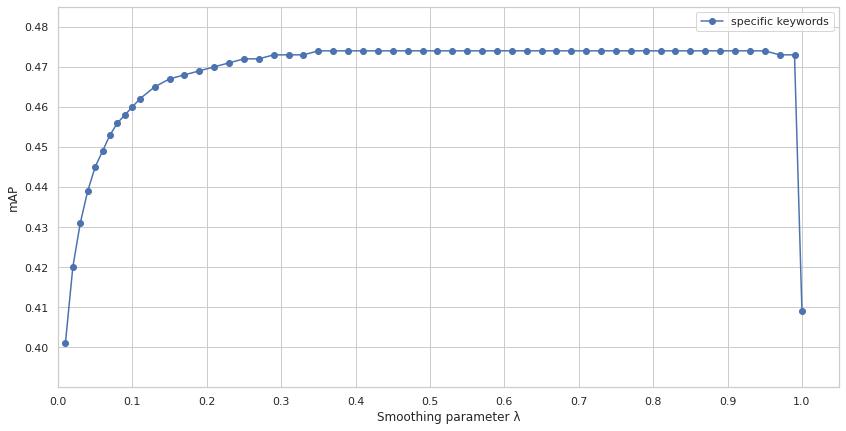

In [11]:
plot_data = search_jm_smoothing_results["specific keywords validation"]["mAP"]["avg"]
err_data = search_jm_smoothing_results["specific keywords validation"]["mAP"]["err"]
plot_data.index = np.round(jm_smoothing_weight_grid,2)
err_data.index = np.round(jm_smoothing_weight_grid,2)
indices1 = list(np.round(np.arange(0.01,0.11,0.01),2))
indices2 = list(np.round(np.arange(0.11,1.0,0.02),2)) + [1.0]
plot_data = plot_data[indices1 + indices2] 
err_data = err_data[indices1 + indices2]
ax = plot_data.plot(label="specific keywords", figsize=(14,7), style="-o", legend=False, xticks=list(np.arange(0,1.1,0.1)), yticks=list(np.arange(0.4,0.5,0.01)), xlim=(0,1.05), ylim=(0.39,0.485))
ax.set_ylabel("mAP");
ax.set_xlabel("Smoothing parameter λ")
ax.legend(loc="upper right")
# ax.axhline(0.474, color="grey", linestyle="--")
# plt.fill_between(plot_data.index, plot_data.values-err_data.values, plot_data.values+err_data.values,
#     alpha=0.2, edgecolor='blue', facecolor='lightblue',
#     linewidth=1)
plt.savefig("images/qlm_jm_lambda_search.pdf", transparent=True, bbox_inches="tight")

## Test dp smoothing

In [15]:
dp_smoothing_weight_grid = [0] + create_grid([0,1,2,3])
search_dp_smoothing = [(f"qlm dp w={w:.2f}", QueryLMRetrievalAlgorithm("dp", w), papers_basic) for w in dp_smoothing_weight_grid]

In [ ]:
search_dp_smoothing_results = train_evaluate_models(search_dp_smoothing, [general_keywords_val, specific_keywords_val], 
                                                    n_jobs=min(20,len(dp_smoothing_weight_grid)))

In [18]:
search_dp_smoothing_results.to_csv("../../data/results/search_dp_smoothing_results.csv")

In [13]:
search_dp_smoothing_results = pd.read_csv("../../data/results/search_dp_smoothing_results.csv", index_col=0, header=[0,1,2])

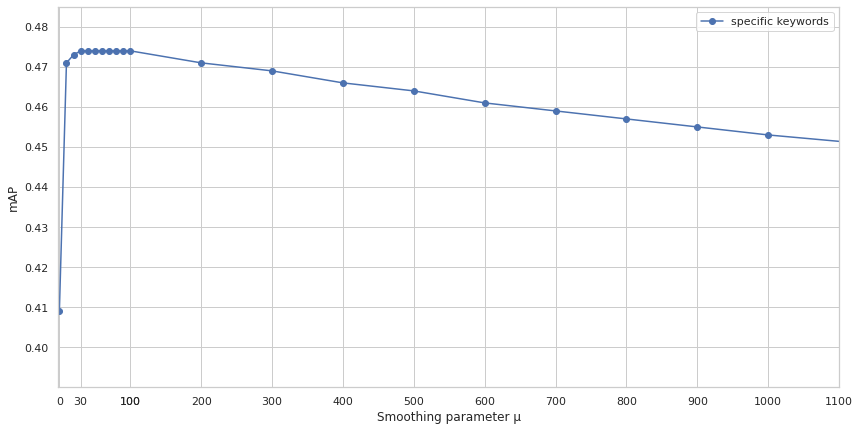

In [16]:
plot_data = search_dp_smoothing_results["specific keywords validation"]["mAP"]["avg"]
err_data = search_dp_smoothing_results["specific keywords validation"]["mAP"]["err"]
plot_data.index = np.round(dp_smoothing_weight_grid,2)
err_data.index = np.round(dp_smoothing_weight_grid,2)
plot_data = pd.concat([plot_data[0:10:10], plot_data[10:20:1], plot_data[20:]])
# indices1 = list(np.round(np.arange(0.01,0.11,0.01),2))
# indices2 = list(np.round(np.arange(0.11,1.0,0.02),2)) + [1.0]
# plot_data = plot_data.loc[:4000] 
# err_data = plot_data.loc[:4000] 
ax = plot_data.plot(label="specific keywords", figsize=(14,7), style="-o", legend=False, yticks=list(np.arange(0.4,0.5,0.01)), xticks=list(np.arange(0,1600,100))+[30,100], xlim=(-2,1100), ylim=(0.39,0.485))
ax.set_ylabel("mAP");
ax.set_xlabel("Smoothing parameter μ")
ax.legend(loc="upper right")
# ax.axhline(0.474, color="grey", linestyle="--")
# plt.fill_between(plot_data.index, plot_data.values-err_data.values, plot_data.values+err_data.values,
#     alpha=0.2, edgecolor='blue', facecolor='lightblue',
#     linewidth=1)
plt.savefig("images/qlm_dp_mu_search.pdf", transparent=True, bbox_inches="tight")

## Test n-grams

In [19]:
ngram_qlm_models = [
    ("qlm no smoothing 1-gram", QueryLMRetrievalAlgorithm("jm",1, max_ngram=1), papers_basic_lemmatization_nouns),
    ("qlm jm w= 1-gram", QueryLMRetrievalAlgorithm("jm",0.65, max_ngram=1), papers_basic_lemmatization_nouns),
    ("qlm dp w= 1-gram", QueryLMRetrievalAlgorithm("dp",65, max_ngram=1), papers_basic_lemmatization_nouns),
    ("qlm no smoothing 2-gram", QueryLMRetrievalAlgorithm("jm",1, max_ngram=2), papers_basic_lemmatization_nouns),
    ("qlm jm w= 2-gram", QueryLMRetrievalAlgorithm("jm",0.65, max_ngram=2), papers_basic_lemmatization_nouns),
    ("qlm dp w= 2-gram", QueryLMRetrievalAlgorithm("dp",65, max_ngram=2), papers_basic_lemmatization_nouns),
]

In [ ]:
ngram_qlm_results = train_evaluate_models(ngram_qlm_models, [general_keywords_val, specific_keywords_val],  n_jobs=len(ngram_qlm_models))

In [21]:
ngram_qlm_results.to_csv("../../data/results/ngram_qlm_results.csv")

In [9]:
ngram_qlm_results = pd.read_csv("../../data/results/ngram_qlm_results.csv", index_col=0, header=[0,1,2])
ngram_qlm_results

general keywords validation                                    specific keywords validation                                   
                                                p@5   p@10   p@20 R-prec    mAP  bpref                          p@5   p@10   p@20 R-prec    mAP  bpref
qlm no smoothing 1-gram                       0.283  0.239  0.202  0.058  0.038  0.046                        0.621  0.558  0.463  0.432  0.422  0.419
qlm jm w= 1-gram                              0.285  0.244  0.209  0.082  0.051  0.061                        0.642  0.586  0.498  0.475  0.480  0.460
qlm dp w= 1-gram                              0.289  0.250  0.211  0.082  0.053  0.061                        0.645  0.589  0.499  0.475  0.480  0.460
qlm no smoothing 2-gram                       0.290  0.237  0.191  0.052  0.038  0.042                        0.695  0.623  0.508  0.481  0.475  0.478
qlm jm w= 2-gram                              0.301  0.252  0.210  0.083  0.053  0.062                        0.731  0.672  0.565  0.550  0.559  0.546
qlm dp w= 2-gram                              0.306  0.259  0.213  0.083  0.054  0.062                        0.730  0.672  0.565  0.548  0.557  0.543

## Save best model

In [ ]:
best_tfidf_model = TfIdfRetrievalAlgorithm(max_ngram=2, use_idf=True, sublinear_tf=True, min_df=2)
best_tfidf_model.prepare(papers_basic_lemmatization_nouns)

In [ ]:
file_path = "../data/models/tfidf/tfidf_lemmatized_bigram.model"
with open(file_path, "wb") as file:
    pickle.dump(best_tfidf_model, file)